# Regelbasierten Klassifikationslogik

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

# Simulationsdaten für 10 Variablen über 1 Tag (1440 Minuten = 24 Stunden)
np.random.seed(42)
minutes = 1440
time_index = pd.date_range(start="2025-01-01", periods=minutes, freq="min")

# Erstellung von Variablen unterschiedlichen Typs
sim_data = pd.DataFrame(index=time_index)
sim_data["temp_sensor"] = np.random.normal(loc=25, scale=2, size=minutes)  # Sensorwert
sim_data["bool_switch"] = np.random.choice([0, 1], size=minutes, p=[0.9, 0.1])  # Boolean
sim_data["config_value"] = 5  # Konstant
sim_data["counter"] = np.cumsum(np.random.poisson(1, size=minutes))  # Zähler
sim_data["status_mode"] = np.random.choice([1, 2, 3], size=minutes, p=[0.97, 0.02, 0.01])  # selten geändert
sim_data["voltage"] = 230 + np.random.normal(0, 5, size=minutes)  # Sensorwert
sim_data["current"] = 5 + np.random.normal(0, 0.5, size=minutes)  # Sensorwert
sim_data["power"] = sim_data["voltage"] * sim_data["current"]  # abhängige Variable
sim_data["noise"] = np.random.normal(0, 0.1, size=minutes)  # niedrigamplitudiger Rauschsensor
sim_data["empty"] = np.nan  # leer

sim_data.reset_index(inplace=True)
sim_data.rename(columns={"index": "timestamp"}, inplace=True)

display(sim_data.head(100))

,timestamp,temp_sensor,bool_switch,config_value,counter,status_mode,voltage,current,power,noise,empty
0,2025-01-01 00:00:00,25.993428,0,5,2,1,238.266548,5.391014,1284.498224,0.020786,NaN
1,2025-01-01 00:01:00,24.723471,0,5,2,1,233.115437,4.544191,1059.321151,0.013260,NaN
2,2025-01-01 00:02:00,26.295377,0,5,2,1,231.199289,4.990041,1153.693884,-0.160322,NaN
3,2025-01-01 00:03:00,28.046060,0,5,2,1,232.431550,4.876060,1133.350170,-0.181488,NaN
4,2025-01-01 00:04:00,24.531693,1,5,3,1,225.007796,4.785841,1076.851505,0.029593,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,2025-01-01 01:35:00,22.072970,1,5,103,1,222.457220,6.202419,1379.772838,-0.121074,NaN
96,2025-01-01 01:36:00,25.592241,0,5,104,1,230.924853,5.108604,1179.703620,-0.093847,NaN
97,2025-01-01 01:37:00,25.522111,0,5,106,1,232.263782,4.767616,1107.344612,-0.054641,NaN
98,2025-01-01 01:38:00,25.010227,0,5,109,1,238.536649,4.411387,1052.277423,-0.028224,NaN


In [2]:
# Python-Vorlage zur automatischen Klassifizierung von Variablen anhand simulierter Daten
import pandas as pd
import numpy as np
from IPython.display import display

# Angenommen, sim_data ist bereits geladen
# Erstellen Sie ein technisches Profil der Variablen

def classify_variable(series):
    unique_vals = series.dropna().unique()
    nunique = len(unique_vals)
    std = series.std()
    changes = (series.shift(1) != series).sum()

    if series.isna().all():
        return "leer"
    elif nunique == 1:
        return "konstant"
    elif set(unique_vals).issubset({0, 1}):
        return "boolean"
    elif std < 0.01:
        return "rauschsignal"
    elif changes < 10:
        return "status"
    elif series.is_monotonic_increasing:
        return "zähler"
    elif series.dtype == float:
        return "sensorwert"
    else:
        return "unbekannt"

# Profiling aller Variablen (außer timestamp)
classification = []
for col in sim_data.columns:
    if col == "timestamp":
        continue
    var_type = classify_variable(sim_data[col])
    classification.append({
        "Name": col,
        "Kategorie": var_type,
        "Aktiv": (sim_data[col].diff().abs() > 0).sum(),
        "Wertebereich": f"{sim_data[col].min():.2f} - {sim_data[col].max():.2f}" if sim_data[col].notna().any() else "n/a",
        "Empfehlung": "relevant" if var_type in ["sensorwert", "boolean", "zähler"] else "prüfen/ignorieren"
    })

classification_df = pd.DataFrame(classification)
display(classification_df)

,Name,Kategorie,Aktiv,Wertebereich,Empfehlung
0,temp_sensor,sensorwert,1439,18.52 - 32.71,relevant
1,bool_switch,boolean,246,0.00 - 1.00,relevant
2,config_value,konstant,0,5.00 - 5.00,prüfen/ignorieren
3,counter,zähler,900,2.00 - 1394.00,relevant
4,status_mode,unbekannt,60,1.00 - 3.00,prüfen/ignorieren
5,voltage,sensorwert,1439,213.89 - 247.65,relevant
6,current,sensorwert,1439,3.08 - 6.69,relevant
7,power,sensorwert,1439,721.42 - 1548.51,relevant
8,noise,sensorwert,1439,-0.39 - 0.29,relevant
9,empty,leer,0,n/a,prüfen/ignorieren


In [3]:
import pandas as pd
import numpy as np
from IPython.display import display # Import display

# Erweiterter Klassifizierungsalgorithmus unter Berücksichtigung von Statistiken und Korrelationen
def extended_classify_variables(df):
    df = df.copy()
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()

    classification = []
    for col in numeric_df.columns:
        series = numeric_df[col]
        unique_vals = series.dropna().unique()
        nunique = len(unique_vals)
        std = series.std()
        changes = (series != series.shift(1)).sum()
        p5, p95 = np.percentile(series.dropna(), [5, 95]) if series.dropna().size else (np.nan, np.nan)
        min_val, max_val = series.min(), series.max()
        extreme_counts = ((series == min_val) | (series == max_val)).sum()
        outlier_ratio = ((series < p5) | (series > p95)).sum() / len(series) if len(series) > 0 else 0
        percentile_span = p95 - p5 if not np.isnan(p95) and not np.isnan(p5) else np.nan
        correlated_vars = corr_matrix[col][(corr_matrix[col] > 0.95) & (corr_matrix[col] < 1.0)].index.tolist()

        if series.isna().all():
            cat = "leer"
        elif nunique == 1:
            cat = "konstant"
        elif set(unique_vals).issubset({0, 1}):
            cat = "boolean"
        elif std < 0.01 or (percentile_span < 0.05 and series.dtype == float):
            cat = "rauschsignal"
        elif changes < 10:
            cat = "status"
        elif series.is_monotonic_increasing:
            cat = "zähler"
        elif outlier_ratio > 0.10:
            cat = "instabil"
        elif extreme_counts / len(series) > 0.2:
            cat = "grenzwertbasiert"
        elif correlated_vars:
            cat = "abhängig"
        elif series.dtype == float and changes > 10:
            cat = "sensorwert"
        else:
            cat = "unbekannt"

        classification.append({
            "Name": col,
            "Kategorie": cat,
            "Aktiv": changes,
            "Wertebereich": f"{min_val:.2f} - {max_val:.2f}" if not np.isnan(min_val) else "n/a",
            "Korrelation with": ", ".join(correlated_vars) if correlated_vars else "-", # Changed key name
            "Empfehlung": "relevant" if cat in ["sensorwert", "boolean", "zähler"] else "prüfen/ignorieren"
        })

    return pd.DataFrame(classification)

# Testen der Simulationsdaten (vorausgesetzt, sim_data ist bereits geladen)
# Removed: sim_data = pd.read_csv("/content/sim_data.csv", parse_dates=["timestamp"])
classified_df = extended_classify_variables(sim_data.drop(columns=["timestamp"]))
# Changed display method
display(classified_df)

,Name,Kategorie,Aktiv,Wertebereich,Korrelation with,Empfehlung
0,temp_sensor,sensorwert,1440,18.52 - 32.71,-,relevant
1,bool_switch,boolean,247,0.00 - 1.00,-,relevant
2,config_value,konstant,1,5.00 - 5.00,-,prüfen/ignorieren
3,counter,zähler,901,2.00 - 1394.00,-,relevant
4,status_mode,grenzwertbasiert,61,1.00 - 3.00,-,prüfen/ignorieren
5,voltage,sensorwert,1440,213.89 - 247.65,-,relevant
6,current,abhängig,1440,3.08 - 6.69,power,prüfen/ignorieren
7,power,abhängig,1440,721.42 - 1548.51,current,prüfen/ignorieren
8,noise,sensorwert,1440,-0.39 - 0.29,-,relevant
9,empty,leer,1440,n/a,-,prüfen/ignorieren


In [4]:
#Option 1
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from IPython.display import display # Import display

# Automatisches Gruppieren korrelierter Variablen nach Themen-Cluster

def gruppiere_korrelierte_variablen(df, schwellenwert=0.95):
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()

    # Schritt 1: Filtere stark korrelierte Paare
    korrelierte_paare = []
    for i, col1 in enumerate(corr_matrix.columns):
        for j, col2 in enumerate(corr_matrix.columns):
            if i < j and corr_matrix.iloc[i, j] > schwellenwert:
                korrelierte_paare.append((col1, col2))

    # Schritt 2: Clustern über Agglomerative Clustering auf Korrelationsbasis
    # Corrected parameter from affinity='precomputed' to metric='precomputed'
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=1 - schwellenwert, metric='precomputed', linkage='complete')
    dist_matrix = 1 - corr_matrix.values
    labels = clustering.fit_predict(dist_matrix)

    # Schritt 3: Mapping Cluster → Variablen
    gruppierung = {}
    for var, label in zip(corr_matrix.columns, labels):
        gruppierung.setdefault(label, []).append(var)

    gruppierung_df = pd.DataFrame([
        {"Themen-Cluster": f"Cluster {k+1}", "Variablen": ", ".join(v)}
        for k, v in gruppierung.items() if len(v) > 1
    ])

    return gruppierung_df

# Beispiel mit simulierten Daten
np.random.seed(1)
df_demo = pd.DataFrame({
    "spannung": np.random.normal(230, 2, 1000),
    "strom": np.random.normal(5, 0.5, 1000),
    "leistung": lambda df: df["spannung"] * df["strom"],
    "temp": np.random.normal(25, 1, 1000),
    "temp2": lambda df: df["temp"] + np.random.normal(0, 0.2, 1000),
})

# Berechnung abhängiger Spalten
df_demo["leistung"] = df_demo["spannung"] * df_demo["strom"]
df_demo["temp2"] = df_demo["temp"] + np.random.normal(0, 0.2, 1000)

# Gruppieren
cluster_ergebnis = gruppiere_korrelierte_variablen(df_demo)
# Changed display method
display(cluster_ergebnis)

,Themen-Cluster,Variablen
0,Cluster 2,"strom, leistung"
1,Cluster 1,"temp, temp2"


# Regelbasierte Klassifizierungslogik

Schritt 1 — Klassifizierung von Variablen
Wir verwenden das bereits vorhandene Skript: Jede Variable erhält eine Kategorie (sensorwert, Zähler, Status etc.).
Schritt 2 — Erstellung thematischer Cluster
Innerhalb jeder Kategorie (z.B. Sensorwert) führen wir eine Clusterbildung basierend auf Korrelation (oder gegenseitiger Information, wenn mehr Zeit zur Verfügung steht) durch.
Schritt 3 — Ergebnisgenerierung
Am Ende: Eine Liste von Clustern innerhalb jeder Kategorie, zum Beispiel:

Sensorwerte:
  - Cluster 1: strom, spannung, leistung
  - Cluster 2: temperatur_1, temperatur_2, luftfeuchte

Statusvariablen:
  - Cluster 1: modus_1, modus_2
  ...


In [5]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from IPython.display import display

# Beispielhafter Klassifikationsoutput
klassifikation = pd.DataFrame({
    "Name": ["strom", "spannung", "leistung", "temperatur", "druck", "modus", "schalter", "config_1", "zaehler"],
    "Kategorie": ["sensorwert", "sensorwert", "sensorwert", "sensorwert", "sensorwert",
                  "status", "boolean", "konfiguration", "zähler"]
})

# Simulierte Zeitreihendaten
np.random.seed(42)
daten = pd.DataFrame({
    "strom": np.random.normal(5, 0.5, 1000),
    "spannung": np.random.normal(230, 2, 1000),
    "temperatur": np.random.normal(25, 1, 1000),
    "druck": np.random.normal(101, 0.3, 1000),
    "modus": np.random.choice([1, 2, 3], 1000, p=[0.8, 0.15, 0.05]),
    "schalter": np.random.choice([0, 1], 1000, p=[0.95, 0.05]),
    "config_1": 42,
    "zaehler": np.cumsum(np.random.poisson(1, 1000)),
})
daten["leistung"] = daten["strom"] * daten["spannung"]

# Verbesserte Cluster-Funktion: erlaubt Einzelcluster, mehrere Cluster
def cluster_pro_kategorie(daten, klassifikation, min_korr=0.85):
    ergebnis = []

    for kategorie in klassifikation["Kategorie"].unique():
        variablen = klassifikation[klassifikation["Kategorie"] == kategorie]["Name"].tolist()
        if not variablen:
            continue

        subset = daten[variablen]
        if subset.shape[1] == 1:
            ergebnis.append({
                "Kategorie": kategorie,
                "Cluster-Gruppe": f"{kategorie}-Cluster 1",
                "Variablen": variablen[0]
            })
            continue

        corr_matrix = subset.corr().abs()
        dist_matrix = 1 - corr_matrix.values

        try:
            clustering = AgglomerativeClustering(
                n_clusters=None,
                distance_threshold=1 - min_korr,
                affinity='precomputed',
                linkage='complete'
            )
            labels = clustering.fit_predict(dist_matrix)
        except Exception as e:
            continue

        for label in np.unique(labels):
            cluster_vars = [variablen[i] for i in range(len(variablen)) if labels[i] == label]
            ergebnis.append({
                "Kategorie": kategorie,
                "Cluster-Gruppe": f"{kategorie}-Cluster {label+1}",
                "Variablen": ", ".join(cluster_vars)
            })

    return pd.DataFrame(ergebnis)

# Anwendung
cluster_df = cluster_pro_kategorie(daten, klassifikation)
print("Erweiterte thematische Cluster (hybrid)")

display(cluster_df)


Erweiterte thematische Cluster (hybrid)


/Users/svitlanakovalivska/miniforge3/envs/anomaly-final-env/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


,Kategorie,Cluster-Gruppe,Variablen
0,sensorwert,sensorwert-Cluster 1,"strom, leistung"
1,sensorwert,sensorwert-Cluster 2,druck
2,sensorwert,sensorwert-Cluster 3,temperatur
3,sensorwert,sensorwert-Cluster 4,spannung
4,status,status-Cluster 1,modus
5,boolean,boolean-Cluster 1,schalter
6,konfiguration,konfiguration-Cluster 1,config_1
7,zähler,zähler-Cluster 1,zaehler


### 🔄 **Hybrid-Integration von Unsupervised ML**

#### **1. Ausgangsbedingungen:**

* Jede Variable hat bereits eine anfängliche **Klassifizierung** durch Regeln (z.B.: `sensorwert`, `status`).
* Innerhalb jeder Gruppe gibt es logisch ähnliche Variablen, aber **ihre innere Struktur wurde noch nicht untersucht**.

#### **2. Integrationsansatz:**

| Schritt | Beschreibung                                                                |
| ---- | ------------------------------------------------------------------- |
| 1    | Extrahieren von Zeitreihenmerkmalen aus jeder Variable (Statistiken, Form) |
| 2    | Erstellen eines Merkmalsvektors für jede Variable                          |
| 3    | Anwenden einer ML-Methode (K-Means, t-SNE, DBSCAN, Autoencoder)          |
| 4    | Erhalten von Clustern innerhalb jeder Kategorie                        |
| 5    | Benennen der Cluster nach Themen oder Verhaltensmustern                  |

#### **3. Merkmale für die Clusterbildung (pro Variable):**

* Mittelwert
* Standardabweichung
* Anzahl der Änderungen
* Anteil der Extremwerte
* Schiefe (Skewness) / Kurtosis
* Frequenzbereich (optional über FFT)

#### **4. Beispiel:**

* `sensorwert` → Cluster 1 (Energie-relevant), Cluster 2 (Temperaturgruppe), Cluster 3 (Feuchtesensoren)
* `status` → Cluster 1 (Zustand Maschine A), Cluster 2 (Modus B)

#### **5. Spezifische ML-Anwendung:**

* t-SNE / UMAP → nur zur Visualisierung
* K-Means / DBSCAN → Gruppenerkennung
* Autoencoder → Anomalieerkennung oder Dimensionsreduktion

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis

# Beispiel-Zeitreihen mit mehreren Variablen
np.random.seed(123)
zeitreihen = pd.DataFrame({
    "var_1": np.random.normal(0, 1, 1000),
    "var_2": np.random.normal(0, 1, 1000) + np.linspace(0, 1, 1000),
    "var_3": np.random.binomial(1, 0.05, 1000),
    "var_4": np.random.poisson(3, 1000),
    "var_5": np.random.normal(10, 5, 1000)
})

# Feature-Vektor aus Zeitreihen für jede Variable berechnen
def berechne_features(df):
    feature_liste = []
    for spalte in df.columns:
        serie = df[spalte]
        feature_liste.append({
            "Name": spalte,
            "Mittelwert": np.mean(serie),
            "Standardabw": np.std(serie),
            "Skewness": skew(serie),
            "Kurtosis": kurtosis(serie),
            "Anzahl Änderungen": (serie.diff().fillna(0) != 0).sum(),
            "Max-Wert": np.max(serie),
            "Min-Wert": np.min(serie)
        })
    return pd.DataFrame(feature_liste)

# Features extrahieren
feature_df = berechne_features(zeitreihen)

# Features für K-Means skalieren
X = feature_df.drop(columns=["Name"])
X_scaled = StandardScaler().fit_transform(X)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
feature_df["Cluster"] = kmeans.fit_predict(X_scaled)
print("Unsupervised ML Clustering (K-Means)")
display(feature_df)

/Users/svitlanakovalivska/miniforge3/envs/anomaly-final-env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Unsupervised ML Clustering (K-Means)


,Name,Mittelwert,Standardabw,Skewness,Kurtosis,Anzahl Änderungen,Max-Wert,Min-Wert,Cluster
0,var_1,-0.039564,1.000788,-0.029040,-0.025439,999,3.571579,-3.231055,0
1,var_2,0.508389,0.997836,-0.138279,0.012956,999,3.508365,-3.162740,0
2,var_3,0.051000,0.219998,4.081860,14.661584,96,1.000000,0.000000,2
3,var_4,2.979000,1.714806,0.572786,0.162275,837,9.000000,0.000000,0
4,var_5,10.040566,5.052682,0.261037,0.201268,999,28.956837,-4.095288,1


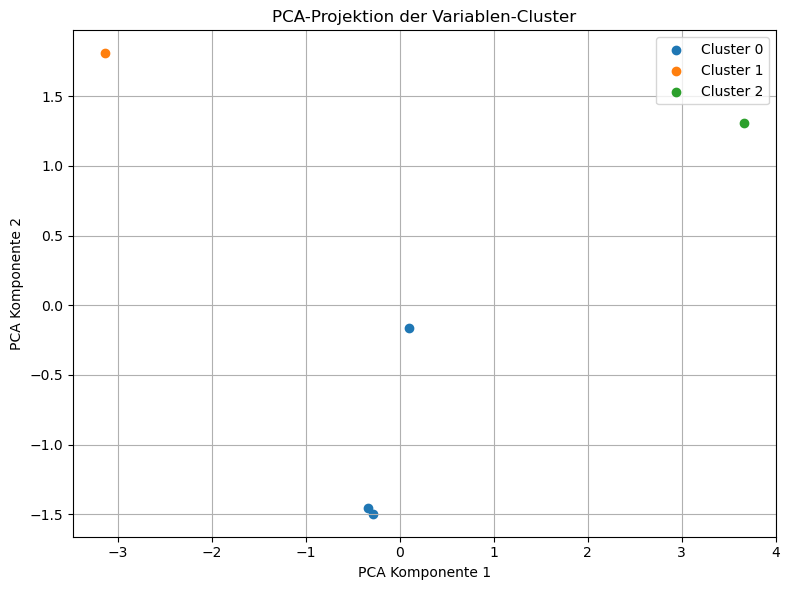

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA zur 2D-Visualisierung
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Streudiagramm mit Clusterfarben
plt.figure(figsize=(8, 6))
for cluster in np.unique(feature_df["Cluster"]):
    plt.scatter(
        X_pca[feature_df["Cluster"] == cluster, 0],
        X_pca[feature_df["Cluster"] == cluster, 1],
        label=f"Cluster {cluster}"
    )

plt.title("PCA-Projektion der Variablen-Cluster")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
#Option 2
import pandas as pd
import numpy as np

# Dynamische Benennung von Clustern basierend auf Perzentilen
def cluster_namen_perzentilbasiert(cluster_df, feature_df, cluster_col="Cluster", name_col="Name"):
    result = []

    # Referenz-Perzentile im Gesamtdatensatz berechnen
    ref_stats = feature_df.drop(columns=[name_col, cluster_col]).quantile([0.1, 0.9])

    for cluster_id in sorted(cluster_df[cluster_col].unique()):
        cluster_vars = cluster_df[cluster_df[cluster_col] == cluster_id][name_col].tolist()
        cluster_features = feature_df[feature_df[name_col].isin(cluster_vars)].drop(columns=[name_col, cluster_col])
        centroid = cluster_features.mean()

        # Dynamische Regeln auf Basis von Perzentilen
        if centroid["Mittelwert"] > ref_stats.loc[0.9, "Mittelwert"] and centroid["Standardabw"] > ref_stats.loc[0.9, "Standardabw"]:
            label = "Energiesensoren"
        elif centroid["Standardabw"] < ref_stats.loc[0.1, "Standardabw"]:
            label = "Statische Signale"
        elif centroid["Skewness"] > ref_stats.loc[0.9, "Skewness"]:
            label = "Ausreißer-empfindlich"
        elif centroid["Anzahl Änderungen"] < ref_stats.loc[0.1, "Anzahl Änderungen"]:
            label = "Modusvariablen"
        elif centroid["Mittelwert"] < ref_stats.loc[0.1, "Mittelwert"] and centroid["Anzahl Änderungen"] > ref_stats.loc[0.9, "Anzahl Änderungen"]:
            label = "Digitale Trigger"
        else:
            label = "Sonstige Sensorgruppe"

        result.append({
            "Cluster-ID": f"Cluster {cluster_id}",
            "Vorschlag": label,
            "Variablen": ", ".join(cluster_vars)
        })

    return pd.DataFrame(result)

# Anwenden der Funktion
cluster_labels_df = cluster_namen_perzentilbasiert(feature_df, feature_df)
cluster_labels_df.head()


,Cluster-ID,Vorschlag,Variablen
0,Cluster 0,Sonstige Sensorgruppe,"var_1, var_2, var_4"
1,Cluster 1,Energiesensoren,var_5
2,Cluster 2,Statische Signale,var_3


Funktion zur automatischen Klassifizierung von Clustern unter Verwendung dynamischer Perzentilschwellenwerte:

Energiesensoren – werden durch einen hohen Mittelwert und eine hohe Standardabweichung definiert (über dem 90. Perzentil).
Statische Signale, Modusvariablen, Digitale Trigger – basierend auf niedrigen oder hohen Quantilen der entsprechenden Metriken.
Wenn nichts davon zutrifft – wird "Sonstige Sensorgruppe" zugewiesen.
Dies gewährleistet eine flexible Anpassung der Klassifizierung an verschiedene Datensätze.

**Kernpunkt dieses Ansatzes:**

Dieser Ansatz verwendet dynamische Perzentil-Schwellenwerte, um Clustern, die mittels unüberwachtem Lernen (wie K-Means) identifiziert wurden, automatisch aussagekräftige Bezeichnungen zuzuweisen. Anstatt feste, willkürliche Zahlen zu verwenden, werden Perzentile basierend auf der Verteilung der Features über alle Variablen in Ihrem Datensatz berechnet. Dies macht die Klassifizierung flexibler und anpassungsfähiger an unterschiedliche Datensätze, da sich die Schwellenwerte an den spezifischen Bereich und die Streuung der Werte in Ihren Daten anpassen.

Hier ist eine Aufschlüsselung der Logik, nach der Sie gefragt haben:

**Energiesensoren: **Diese werden durch einen hohen Mittelwert und eine hohe Standardabweichung identifiziert, insbesondere oberhalb des 90. Perzentils dieser Metriken über alle Variablen im Datensatz.
Begründung: Variablen im Zusammenhang mit Energie (wie Spannung, Strom, Leistung) haben oft höhere Durchschnittswerte und tendieren dazu, stärker zu schwanken als beispielsweise Temperatur- oder Statussignale. Das 90. Perzentil dient als dynamischer Schwellenwert, um Variablen zu erfassen, die diese Eigenschaften im Vergleich zum Rest des Datensatzes aufweisen. Wenn eine Variable konstant einen hohen Durchschnittswert und eine große Streuung aufweist, erfasst sie wahrscheinlich einen "energetischeren" oder dynamischeren Prozess.

**Statische Signale, Modusvariablen, Digitale Trigger:** Diese Kategorien werden basierend auf niedrigen oder hohen Quantilen (Perzentilen) spezifischer Metriken zugewiesen:
Statische Signale: Werden wahrscheinlich durch eine sehr niedrige Standardabweichung identifiziert (z. B. unterhalb des 10. Perzentils). Diese Variablen ändern sich sehr wenig im Laufe der Zeit.

**Modusvariablen:** Haben oft eine geringe Anzahl von Änderungen (z. B. unterhalb des 10. Perzentils der Metrik "Anzahl der Änderungen"), da sie Betriebsmodi repräsentieren, die nicht häufig wechseln.
Digitale Trigger: Können durch einen niedrigen Mittelwert (wenn sie einen "Aus"-Zustand repräsentieren) und eine hohe Anzahl von Änderungen (wenn sie schnell zwischen Zuständen wechseln) identifiziert werden, möglicherweise unter Verwendung von Schwellenwerten wie unterhalb des 10. Perzentils für den Mittelwert und oberhalb des 90. Perzentils für die Anzahl der Änderungen.

**Begründung:** Diese Kategorien repräsentieren Variablen mit ausgeprägtem, oft weniger dynamischem Verhalten im Vergleich zu typischen Sensorwerten. Die Verwendung von niedrigen oder hohen Quantilen spezifischer Metriken wie Standardabweichung, Anzahl der Änderungen oder Schiefe hilft dabei, diese Muster dynamisch zu isolieren. Die spezifischen Perzentil-Schwellenwerte (wie 10. oder 90.) werden gewählt, da sie die "Schwänze" der Verteilung darstellen und Variablen erfassen, die sich signifikant vom Durchschnittsverhalten unterscheiden. Die genauen Perzentilwerte sind abstimmbare Parameter, die Sie basierend auf Ihrem Domänenwissen und den Eigenschaften Ihrer Daten anpassen können.

**Sonstige Sensorgruppe:** Dies ist die Standardkategorie, die zugewiesen wird, wenn keine der spezifischen Regeln für "Energiesensoren", "Statische Signale, Modusvariablen, Digitale Trigger" (oder andere spezifische Regeln, die in der Funktion definiert sind) erfüllt ist.

**Begründung:** Nicht alle Cluster passen perfekt in vordefinierte Kategorien. Diese Sammelkategorie stellt sicher, dass jeder Cluster eine Bezeichnung erhält, auch wenn seine Eigenschaften nicht stark mit den spezifischeren Regeln übereinstimmen. Variablen in dieser Gruppe können moderate Werte, typische Variabilität oder eine Mischung von Merkmalen aufweisen, die die spezifischeren Perzentil-basierten Regeln nicht auslösen. Für Cluster in dieser Gruppe kann eine weitere manuelle Inspektion erforderlich sein.
Warum diese spezifischen Schwellenwerte (wie 10. und 90. Perzentil)?

Diese Perzentile werden verwendet, weil sie eine datenbasierte Möglichkeit bieten, "hoch" und "niedrig" relativ zum gesamten Datensatz zu definieren.

**Das 90. Perzentil** bedeutet, dass ein Wert höher ist als 90 % aller anderen Werte für diese Metrik im Datensatz. Dies ist ein gängiger Schwellenwert, um Werte zu identifizieren, die signifikant höher als der typische Bereich sind.
**Das 10. Perzentil** bedeutet, dass ein Wert niedriger ist als 90 % aller anderen Werte für diese Metrik. Dies wird verwendet, um Werte zu identifizieren, die signifikant niedriger als der typische Bereich sind.
Die Verwendung von Perzentilen macht die Klassifizierungsregeln robust gegenüber Änderungen im Gesamtmaßstab oder der Verteilung Ihrer Daten. Wenn Sie feste Schwellenwerte verwenden (z. B. "Standardabweichung > 10"), funktioniert diese Regel möglicherweise für einen Datensatz, ist aber für einen anderen mit unterschiedlichen Variablenbereichen völlig ungeeignet. Perzentile passen sich an den vorliegenden Datensatz an und machen die Klassifizierung allgemeingültiger.

**Zusammenfassend** lässt sich sagen, dass dieser Perzentil-basierte Ansatz eine flexible und automatisierte Möglichkeit bietet, die Eigenschaften von Variablen-Clustern zu interpretieren, indem Cluster-Schwerpunkte (durchschnittliche Features) dynamisch mit der Gesamtverteilung der Features über alle Variablen verglichen werden. Die spezifischen Perzentilwerte sind abstimmbare Parameter, die Sie basierend auf Ihrem Domänenwissen und den Eigenschaften Ihrer Daten anpassen können.

In [9]:
from graphviz import Digraph

# Erstellung eines Flussdiagramms
dot = Digraph(comment='Pipeline Architektur')

dot.node('A', 'Live-Datenquelle\n(InfluxDB / CSV)')
dot.node('B', 'Datenerfassung\n(Pandas)')
dot.node('C', 'Statistik &\nZeitreihenanalyse')
dot.node('D', 'Regelbasierte\nKlassifikation')
dot.node('E', 'Kategorie-Zuordnung\n(z. B. Sensor, Status)')
dot.node('F', 'Feature-Vektoren\npro Variable')
dot.node('G', 'Clustering\n(K-Means, DBSCAN)')
dot.node('H', 'Cluster-Benennung\n(Perzentil-Analyse)')
dot.node('I', 'Ausgabe\n(Tabelle / Dashboard / Export)')

# Festlegung der Verbindungen
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HI'])

# Anzeigen
dot.render('pipeline_architektur', format='png', cleanup=False)
dot.view()

'pipeline_architektur.pdf'

In [10]:
from graphviz import Digraph

dot = Digraph(comment='Erweiterte Klassifikationspipeline')
dot.attr(rankdir='TB', size='8,10')

# Hauptblöcke
dot.node('A', 'Live-Datenquelle\n(InfluxDB / CSV)')
dot.node('B', 'Datenerfassung\n(Pandas)')
dot.node('C', 'Statistik &\nZeitreihenanalyse')
dot.node('D', 'Regelbasierte\nKlassifikation')

# Entscheidungsbaum
dot.node('D1', '→ Kategorie:\nleer')
dot.node('D2', '→ Kategorie:\nkonstant')
dot.node('D3', '→ Kategorie:\nboolean')
dot.node('D4', '→ Kategorie:\nrauschsignal')
dot.node('D5', '→ Kategorie:\nstatus')
dot.node('D6', '→ Kategorie:\nzähler')
dot.node('D7', '→ Kategorie:\nsensorwert')
dot.node('D8', '→ Kategorie:\ninstabil')
dot.node('D9', '→ Kategorie:\ngrenzwertbasiert')
dot.node('D10', '→ Kategorie:\nabhängig')
dot.node('D11', '→ Kategorie:\nunbekannt')

# Nachklassifikation
dot.node('E', 'Feature-Vektor\nerstellen')
dot.node('F', 'Unsupervised Clustering\n(K-Means, DBSCAN)')
dot.node('G', 'Cluster-Benennung\n(Perzentilregel)')
dot.node('H', 'Ergebnis-Tabelle /\nExport')

# Verbindungen
dot.edges(['AB', 'BC', 'CD'])
dot.edge('D', 'D1', label='alle Werte fehlend')
dot.edge('D', 'D2', label='alle Werte gleich')
dot.edge('D', 'D3', label='nur 0/1')
dot.edge('D', 'D4', label='std < 0.01')
dot.edge('D', 'D5', label='< 10 Änderungen')
dot.edge('D', 'D6', label='monoton wachsend')
dot.edge('D', 'D7', label='viele Änderungen & float')
dot.edge('D', 'D8', label='>10% Ausreißer')
dot.edge('D', 'D9', label='häufig Extremwerte')
dot.edge('D', 'D10', label='starke Korrelation')
dot.edge('D', 'D11', label='nichts davon')

# Weiterführend
for dx in ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11']:
    dot.edge(dx, 'E')

dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')

# Export und Anzeige
dot.render('klassifikations_pipeline_erweitert', format='png', cleanup=False)
dot.view()


'klassifikations_pipeline_erweitert.pdf'

In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
import matplotlib.pyplot as plt

# Klassifikations- und Analysepipeline mit Entscheidungsbaum-Logik

def analysiere_variablen(df):
    result = []
    df_numeric = df.select_dtypes(include=np.number)
    corr_matrix = df_numeric.corr().abs()

    for col in df_numeric.columns:
        series = df_numeric[col]
        series_clean = series.dropna()
        unique_vals = series_clean.unique()
        nunique = len(unique_vals)
        std = series_clean.std()
        changes = (series_clean != series_clean.shift(1)).sum()
        p5, p95 = np.percentile(series_clean, [5, 95]) if len(series_clean) > 0 else (np.nan, np.nan)
        outlier_ratio = ((series_clean < p5) | (series_clean > p95)).sum() / len(series_clean) if len(series_clean) > 0 else 0
        extreme_count = ((series_clean == series_clean.min()) | (series_clean == series_clean.max())).sum()
        extreme_freq = extreme_count / len(series_clean) if len(series_clean) > 0 else 0
        correlated_vars = corr_matrix[col][(corr_matrix[col] > 0.95) & (corr_matrix[col] < 1.0)].index.tolist()
        skew_val = skew(series_clean) if len(series_clean) > 2 else 0
        pspan = p95 - p5

        # Entscheidungslogik
        if series.isna().all():
            cat = "leer"
        elif nunique == 1:
            cat = "konstant"
        elif set(unique_vals).issubset({0, 1}):
            cat = "boolean"
        elif std < 0.01 or (pspan < 0.05 and series.dtype == float):
            cat = "rauschsignal"
        elif changes < 10:
            cat = "status"
        elif series.is_monotonic_increasing:
            cat = "zähler"
        elif outlier_ratio > 0.10:
            cat = "instabil"
        elif extreme_freq > 0.2:
            cat = "grenzwertbasiert"
        elif correlated_vars:
            cat = "abhängig"
        elif series.dtype == float and changes > 10:
            cat = "sensorwert"
        else:
            cat = "unbekannt"

        result.append({
            "Name": col,
            "Kategorie": cat,
            "Mittelwert": series.mean(),
            "Standardabw": std,
            "Skewness": skew_val,
            "Anzahl Änderungen": changes,
            "Korrelation mit": ", ".join(correlated_vars) if correlated_vars else "-",
        })

    return pd.DataFrame(result)

# Beispiel-Daten simulieren
np.random.seed(42)
sim_data = pd.DataFrame({
    "temp": np.random.normal(25, 0.5, 1000),
    "strom": np.random.normal(10, 2, 1000),
    "spannung": np.random.normal(220, 5, 1000),
    "modusschalter": np.random.choice([0, 1], 1000),
    "zähler": np.cumsum(np.random.randint(0, 2, 1000)),
    "fehlercode": [1] * 1000,
    "rausch": np.random.normal(0, 0.001, 1000),
})

classified = analysiere_variablen(sim_data)
classified


/var/folders/t0/f0dxth6149d03d5n4n024r6h0000gn/T/ipykernel_46621/2305553601.py:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(series_clean) if len(series_clean) > 2 else 0


,Name,Kategorie,Mittelwert,Standardabw,Skewness,Anzahl Änderungen,Korrelation mit
0,temp,sensorwert,25.009666,0.489608,0.116801,1000,-
1,strom,sensorwert,10.141672,1.994909,-0.049322,1000,-
2,spannung,sensorwert,220.029171,4.917271,0.061155,1000,-
3,modusschalter,boolean,0.510000,0.500150,-0.040008,497,-
4,zähler,zähler,240.190000,137.188318,0.043990,486,-
5,fehlercode,konstant,1.000000,0.000000,NaN,1,-
6,rausch,rauschsignal,-0.000060,0.000985,-0.186780,1000,-


In [13]:
#Export der finalen Ergebnistabelle als CSV-Datei

output_path = "/Users/svitlanakovalivska/variable_classifier_app/output/klassifikation_ergebnisse_simulation.csv"
classified.to_csv(output_path, index=False)

print(f" Die Datei wurde erfolgreich gespeichert: {output_path}")

 Die Datei wurde erfolgreich gespeichert: /Users/svitlanakovalivska/variable_classifier_app/output/klassifikation_ergebnisse_simulation.csv
